In [42]:
import tensorflow as tf
import librosa
import numpy as np
from PIL import Image
import pretty_midi_fluidsynth as pmf

import os
from pathlib import Path
from tqdm import tqdm

In [43]:
data_path = './test_data'
x_path = os.path.join(data_path,'wav')
y_path = os.path.join(data_path,'midi')

In [44]:
sample_num = len(os.listdir(x_path))
sample_num

180

In [45]:
hop_len = 441
freq_w = 4
octave = 8

n_bins = 12*freq_w*octave
bins_per_octave = 12*freq_w

sr = 44100
fs = 25

start_pitch = 24
end_pitch = 120

# TFRecord 쓰기

In [46]:
filename = "cqt-piano_roll.tfrecord"

In [47]:
writer = tf.io.TFRecordWriter(filename)
example = tf.train.SequenceExample()

example.context.feature['n_bins'].int64_list.value.append(n_bins)
example.context.feature['bins_per_octave'].int64_list.value.append(bins_per_octave)
example.context.feature['hop_length'].int64_list.value.append(hop_len)
example.context.feature['freq_width'].int64_list.value.append(freq_w)
example.context.feature['octave'].int64_list.value.append(octave)
example.context.feature['sampling_rate'].int64_list.value.append(sr)
example.context.feature['piano_roll_fs'].int64_list.value.append(fs)

piano_roll_n_bins = end_pitch-start_pitch

assert(n_bins//freq_w==piano_roll_n_bins)

example.context.feature['piano_roll_n_bins'].int64_list.value.append(piano_roll_n_bins)

cqt_list = example.feature_lists.feature_list["x"]
piano_roll = example.feature_lists.feature_list['y']
for x_file,y_file in tqdm(zip(os.listdir(x_path),os.listdir(y_path)),
                          total=sample_num):
    
    path = os.path.join(y_path, y_file)
    pm = pmf.PrettyMIDI(path)
    pr = pm.get_piano_roll(fs)
    array = pr[start_pitch:end_pitch,:].astype(np.uint8)
    
    piano_roll.feature.add().bytes_list.value.append(
        array.tobytes()
    )
    
    sec = array.shape[1]//fs
    
    path = os.path.join(x_path, x_file)
    audio_data, _ = librosa.load(path,sr=sr)
    cqt = librosa.cqt(audio_data, sr=sr,
                      hop_length= hop_len,
                      n_bins= 12*freq_w*octave,
                      bins_per_octave= 12*freq_w,
                     )
    x = np.abs(cqt[:,:sr//hop_len*sec]).astype(np.float32)
    cqt_list.feature.add().bytes_list.value.append(
        x.tobytes()
    )
    
    
writer.write(example.SerializeToString())

100%|██████████| 180/180 [26:34<00:00,  8.86s/it]


# TFRecord 읽기

In [48]:
context_description = {
    'n_bins': tf.io.FixedLenFeature([],tf.int64,
                                    default_value=0),
    'bins_per_octave':tf.io.FixedLenFeature([],tf.int64,
                                            default_value=0),
    'hop_length':tf.io.FixedLenFeature([],tf.int64,
                                       default_value=0),
    'freq_width':tf.io.FixedLenFeature([],tf.int64,
                                       default_value=0),
    'octave':tf.io.FixedLenFeature([],tf.int64,
                                   default_value=0),
    'sampling_rate':tf.io.FixedLenFeature([],tf.int64,
                                          default_value=0),
    'piano_roll_fs':tf.io.FixedLenFeature([],tf.int64,
                                          default_value=0),
    'piano_roll_n_bins':tf.io.FixedLenFeature([],tf.int64,
                                          default_value=0),
}

sequence_description = {
    'x': tf.io.FixedLenSequenceFeature([], tf.string),
    'y': tf.io.FixedLenSequenceFeature([], tf.string),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_sequence_example(example_proto,
                                             context_description,
                                             sequence_description,)

In [49]:
import matplotlib.pyplot as plt
import librosa.display

raw_ds = tf.data.TFRecordDataset(filename)
parsed_ds = raw_ds.map(_parse_function)
for ds in parsed_ds.take(1):
    print(type(ds))
    print(len(ds))
    print(type(ds[0]))
    print(ds[0].keys())
    print(type(ds[1]))
    print(ds[1].keys())
    
    context, sequence = ds

<class 'tuple'>
2
<class 'dict'>
dict_keys(['bins_per_octave', 'freq_width', 'hop_length', 'n_bins', 'octave', 'piano_roll_fs', 'piano_roll_n_bins', 'sampling_rate'])
<class 'dict'>
dict_keys(['x', 'y'])


In [50]:
cqt = tf.io.decode_raw(sequence['x'][1],
                       tf.float32
                      ).numpy().reshape(n_bins,-1)
cqt.shape

(384, 1200)

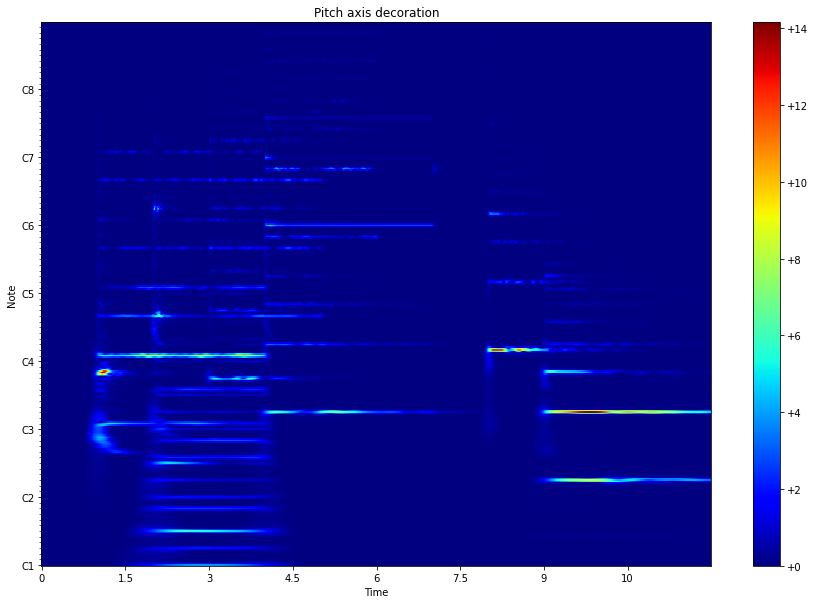

In [51]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
img = librosa.display.specshow(cqt, sr=sr,
                               x_axis='time',
                               y_axis='cqt_note',
                               ax=ax,
                               hop_length= hop_len,
                               bins_per_octave= 12*freq_w,
                               cmap='jet'
                               )
ax.set(title='Pitch axis decoration')
fig.colorbar(img, ax=ax, format="%+2d")
# for i in beat_times:
#     ax.axvline(i,c='k')

plt.show()

In [88]:
piano_roll = tf.io.decode_raw(sequence['y'][1],
                              tf.uint8
                             ).numpy().reshape(end_pitch-start_pitch,-1)
piano_roll.shape

(96, 300)

c:\Users\AI_server\miniconda3\envs\MA\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  return f(*args, **kwargs)


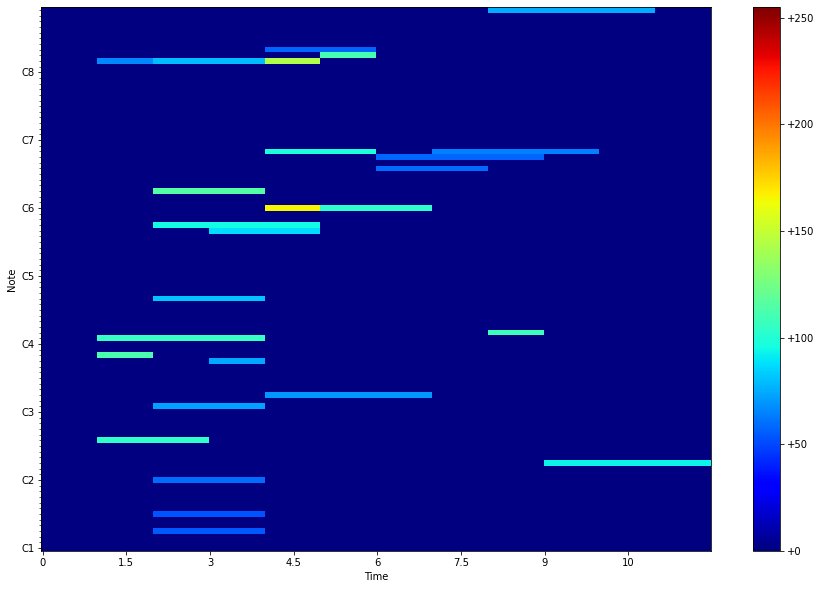

In [103]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
img = librosa.display.specshow(
    piano_roll,
    hop_length=1,
    sr=fs,
    ax=ax,
    x_axis='time',
    y_axis='cqt_note',
    cmap='jet',
    fmin=pmf.note_number_to_hz(start_pitch),
    vmin=0,
    vmax=255,
)
fig.colorbar(img, ax=ax, format="%+2d")
plt.show()

In [90]:
piano_roll.max()

166

# piano_roll to midi

In [121]:
def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0, start_pitch=24):
    
    notes = piano_roll.shape[0] + start_pitch
    pm = pmf.PrettyMIDI()
    instrument = pmf.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(start_pitch, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        if velocity > 126:
            velocity = 126
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity

        else:
            pm_note = pmf.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

In [122]:
midi_data = piano_roll_to_pretty_midi(piano_roll,fs)
midi_data.write('sample.mid')

In [123]:
midi_data = pmf.PrettyMIDI('sample.mid')

pr = midi_data.get_piano_roll(fs)

start_pitch = 24
end_pitch = 120

pr[start_pitch:end_pitch,:].shape

(96, 300)

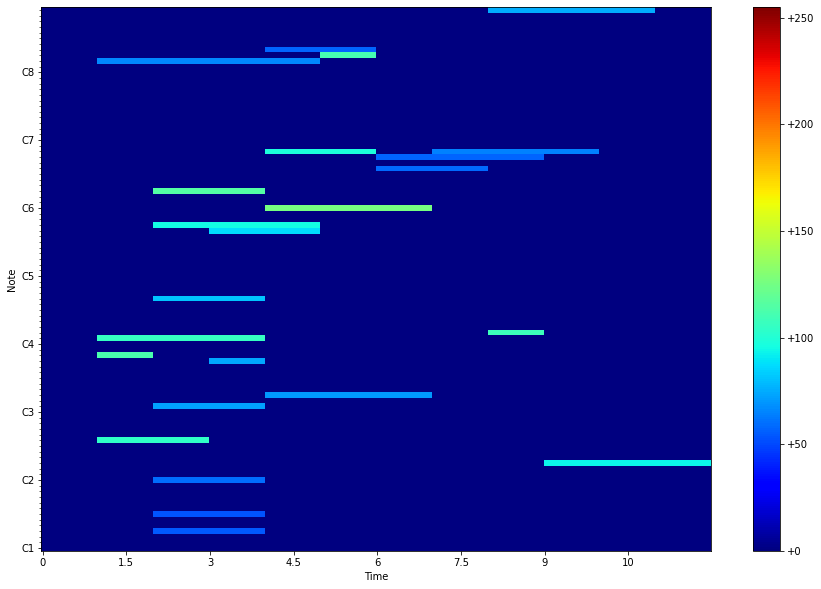

In [124]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
img = librosa.display.specshow(
    pr[start_pitch:end_pitch,:],
    hop_length=1,
    sr=fs,
    ax=ax,
    x_axis='time',
    y_axis='cqt_note',
    cmap='jet',
    fmin=pmf.note_number_to_hz(start_pitch),
    vmin=0,
    vmax=255,
)
fig.colorbar(img, ax=ax, format="%+2d")
plt.show()